### Parse training data

Assumes data is on "./data". For example, download [reichstag](https://vision.uvic.ca/imw-challenge/TrainingData/reichstag.tar.gz) (smallest scene, ~300 Mb) and place it there.

Assumes colmap repository on this folder: e.g. symlink it from `third_party/colmap`.

In [4]:
# select the data
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from colmap.scripts.python.read_write_model import read_model, qvec2rotmat
from colmap.scripts.python.read_dense import read_array
from imageio import imread
import matplotlib.pyplot as plt
import h5py
import deepdish as dd
from time import time

root = './data'
seq = 'reichstag'
src = root + '/' + seq
print(f'Done')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [6]:
# load reconstruction from colmap
cameras, images, points = read_model(path=src + '/dense/sparse', ext='.bin')

print(f'Cameras: {len(cameras)}')
print(f'Images: {len(images)}')
print(f'3D points: {len(points)}')

indices = [i for i in cameras]

Cameras: 75
Images: 75
3D points: 17823


Number of (valid) points: 1669
Number of (total) points: 4259


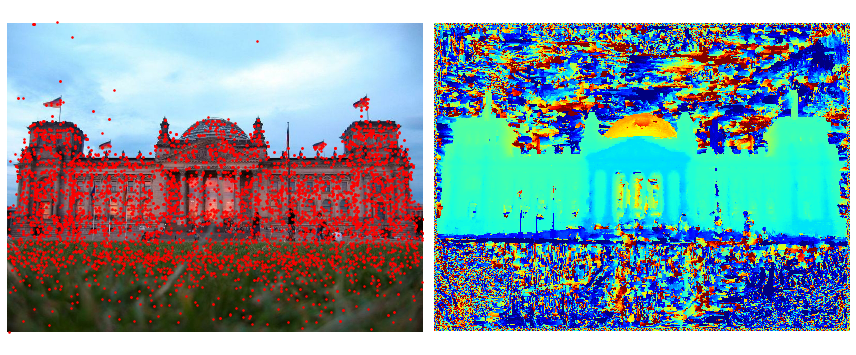

In [7]:
# Retrieve one image, the depth map, and 2D points
def get_image(idx):
    im = imread(src + '/dense/images/' + images[idx].name)
    depth = read_array(src + '/dense/stereo/depth_maps/' + images[idx].name + '.photometric.bin')
    min_depth, max_depth = np.percentile(depth, [5, 95])
    depth[depth < min_depth] = min_depth
    depth[depth > max_depth] = max_depth

    # reformat data
    q = images[idx].qvec
    R = qvec2rotmat(q)
    T = images[idx].tvec
    p = images[idx].xys
    pars = cameras[idx].params
    K = np.array([[pars[0], 0, pars[2]], [0, pars[1], pars[3]], [0, 0, 1]])
    pids = images[idx].point3D_ids
    v = pids >= 0
    print('Number of (valid) points: {}'.format((pids > -1).sum()))
    print('Number of (total) points: {}'.format(v.size))
    
    # get also the clean depth maps
    base = '.'.join(images[idx].name.split('.')[:-1])
    with h5py.File(src + '/dense/stereo/depth_maps_clean_300_th_0.10/' + base + '.h5', 'r') as f:
        depth_clean = f['depth'].value

    return {
        'image': im,
        'depth_raw': depth,
        'depth': depth_clean,
        'K': K,
        'q': q,
        'R': R,
        'T': T,
        'xys': p,
        'ids': pids,
        'valid': v}

idx = indices[0]
data = get_image(idx)

# plot the image and the points that match to the 3D model
ms = 3
fig = plt.figure(figsize=(12, 12))
fig.add_subplot(1, 2, 1)
f1 = plt.imshow(data['image'])
plt.plot(data['xys'][:, 0], data['xys'][:, 1], 'r.', markersize=ms)
plt.plot(data['xys'][data['valid'], 0], data['xys'][data['valid'], 1], 'r.', markersize=ms)
plt.axis('off')

# plot the depth map
fig.add_subplot(1, 2, 2)
f2 = plt.imshow(data['depth_raw'])
# f2 = plt.imshow(data['depth'].astype(np.float))
f2.set_cmap('jet')
plt.axis('off')
fig.tight_layout()
plt.show()

(-0.5, 816.5, 605.5, -0.5)

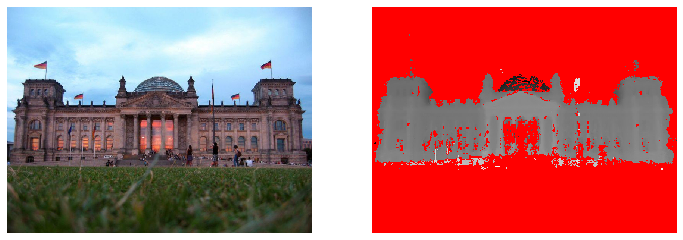

In [8]:
# These depth maps are "dirty", we cleaned them up
# They are included
fig = plt.figure(figsize=(12, 12))

f1 = fig.add_subplot(1, 2, 1)
plt.imshow(data['image'])
plt.axis('off')

f2 = fig.add_subplot(1, 2, 2)
depth = data['depth']
occ = depth == 0
rgb = depth.copy()
rgb[depth > 0] = (rgb[depth > 0].max() - rgb[depth > 0]) / (rgb[depth > 0].max() - rgb[depth > 0].min())
rgb = rgb[None, ...].repeat(3, axis=0)
rgb[0][occ] = 1
rgb[1][occ] = 0
rgb[2][occ] = 0
plt.imshow(rgb.transpose((1, 2, 0)).astype(np.float))
plt.axis('off')

In [9]:
# We can just retrieve all the 3D points
xyz, rgb = [], []
for i in points:
    xyz.append(points[i].xyz)
    rgb.append(points[i].rgb)
xyz = np.array(xyz)
rgb = np.array(rgb)

# you can also retrieve the points that can be found for this image only
cur = []
subset = []
for p in data['ids']:
    if p >= 0:
        cur.append(points[p].xyz)
        subset.append(p)
cur = np.array(cur)

print(xyz.shape)
print(cur.shape)

(17823, 3)
(1669, 3)


In [11]:
# And plot them
# (this requires plotly and is pretty heavy for the big models)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
scatter = dict(
    mode="markers",
    name="Full",
    type="scatter3d",    
    x=x,
    y=y,
    z=z,
    marker = dict(size=1, color="rgb(0, 0, 255)"),
)

x2, y2, z2 = cur[:, 0], cur[:, 1], cur[:, 2]
scatter2 = dict(
    mode="markers",
    name="Image",
    type="scatter3d",    
    x=x2,
    y=y2,
    z=z2,
    marker = dict(size=2, color="rgb(255, 0, 0)"),
)

rg = [
        [min((x.min(), x2.min())), max((x.max(), x2.max()))],
        [min((y.min(), y2.min())), max((y.max(), y2.max()))],
        [min((z.min(), z2.min())), max((z.max(), z2.max()))],
     ]

layout = dict(
    title = 'Point cloud',
    scene = dict(
        xaxis = dict(zeroline=False, range=rg[0]),
        yaxis = dict(zeroline=False, range=rg[1]),
        zaxis = dict(zeroline=False, range=rg[2]),
    )
)

# all points (red) and image points (blue)
# fig = dict( data=[scatter2, scatter], layout=layout )

# only image points
fig = dict( data=[scatter2], layout=layout )

iplot(fig, filename='3d point clustering')
print('Done')

Done


(-0.5, 816.5, 605.5, -0.5)

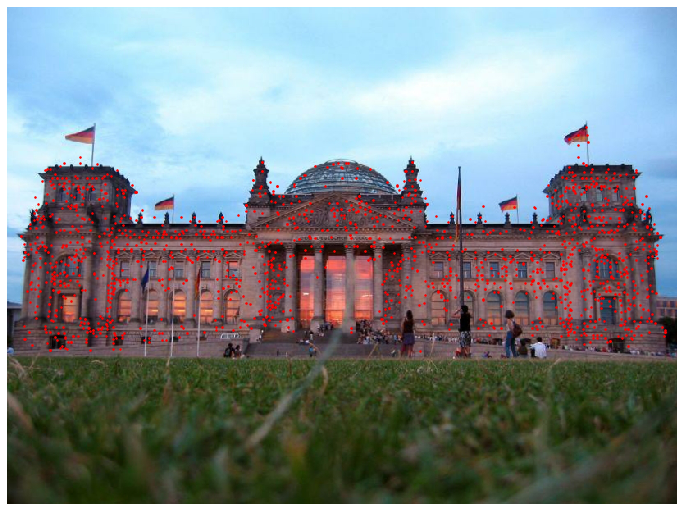

In [12]:
# We can also use the calibration data
# to project the points on the camera plane
depth = data['depth']
K = data['K']
R = data['R']
T = data['T']

p_proj = np.dot(K, np.dot(R, cur.T) + T[..., None])
p_proj = p_proj / p_proj[2, :]

fig = plt.figure(figsize=(12, 12))
f = plt.imshow(data['image'])
plt.plot(p_proj[0, :], p_proj[1, :], 'r.', markersize=3)
plt.axis('off')

In [30]:
# We also provide a measure of how images overlap, based on the bounding boxes
# of the 2D points they have in common
t = time()
# each pair contains [bbox1, bbox2, visibility1, visibility2, # of shared matches]
pairs = dd.io.load(src + '/dense/stereo/pairs-dilation-0.00-fixed2.h5')
print(f'Done ({time() - t:.2f} s.)')

Done (0.11 s.)


In [31]:
# Threshold at a given value
# pairs[p][0]: ratio between the area of the bounding box containing common points and that of image 1
# pairs[p][1]: same for image 2
th = 0.3

filtered = []
for p in pairs:
    if pairs[p][0] >= th and pairs[p][1] >= th:
        idx1, idx2 = p
        # print(f'Valid pair: ({idx1}, {idx2}), ths=({pairs[p][2]:.2f}, {pairs[p][3]:.2f})')
        filtered += [p]
print(f'Valid pairs: {len(filtered)}/{len(pairs)}')
pairs = filtered

Valid pairs: 1120/2775


Showing pair: (75, 74)
Number of (valid) points: 1669
Number of (total) points: 4259
Number of (valid) points: 1651
Number of (total) points: 5201
In common: 558


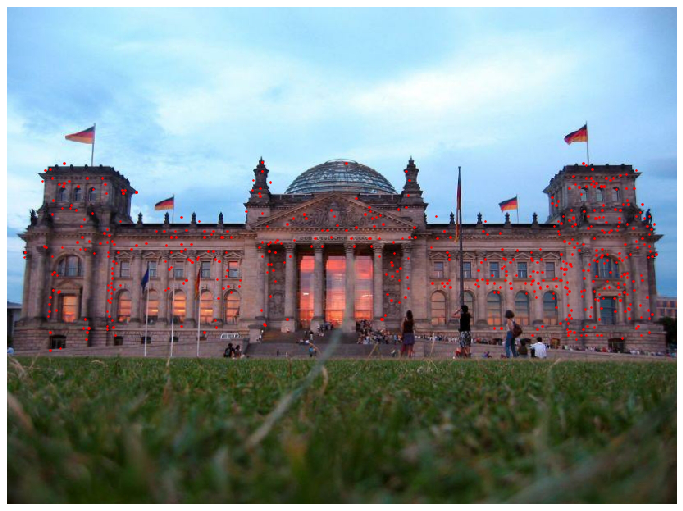

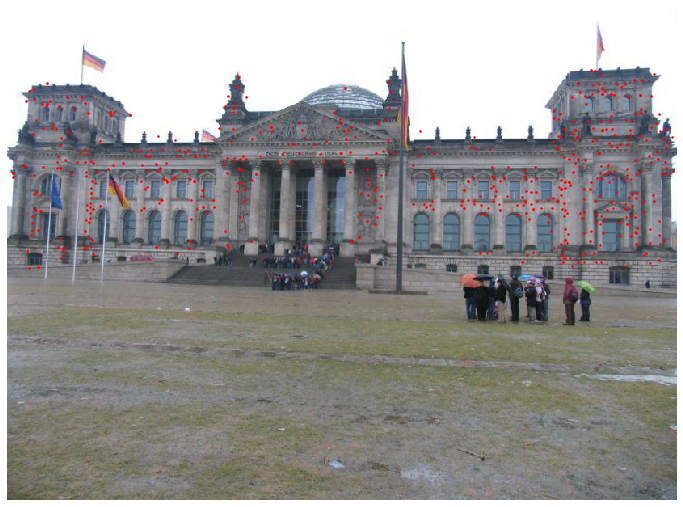

In [41]:
# pick one pair (e.g. the third one)
# These two images should be matchable
idx1, idx2 = pairs[0]
print('Showing pair: ({}, {})'.format(idx1, idx2))
data1 = get_image(idx1)
data2 = get_image(idx2)

# Find the points in common
v1 = data1['ids'][data1['ids'] > 0]
v2 = data2['ids'][data2['ids'] > 0]
common = np.intersect1d(v1, v2)
print('In common: {}'.format(len(common)))
cur = []
for p in common:
    cur.append(points[p].xyz)
cur = np.array(cur)
cur1, cur2 = cur, cur

# Project them separately onto each image
depth1 = data1['depth']
K1 = data1['K']
R1 = data1['R']
T1 = data1['T']
p_proj1 = np.dot(K1, np.dot(R1, cur1.T) + T1[..., None])
p_proj1 = p_proj1 / p_proj1[2, :]

depth2 = data2['depth']
K2 = data2['K']
R2 = data2['R']
T2 = data2['T']
p_proj2 = np.dot(K2, np.dot(R2, cur2.T) + T2[..., None])
p_proj2 = p_proj2 / p_proj2[2, :]

# Eliminate weird points (not sure why but it can happen?)
inv = np.bitwise_and(
    np.bitwise_and(p_proj1[0, :] >= 0, p_proj1[0, :] < data1['image'].shape[1]),
    np.bitwise_and(p_proj1[1, :] >= 0, p_proj1[1, :] < data1['image'].shape[0])
)
p_proj1 = p_proj1[:, inv]

inv = np.bitwise_and(
    np.bitwise_and(p_proj2[0, :] >= 0, p_proj2[0, :] < data2['image'].shape[1]),
    np.bitwise_and(p_proj2[1, :] >= 0, p_proj2[1, :] < data2['image'].shape[0])
)
p_proj2 = p_proj2[:, inv]

# Plot them
fig1 = plt.figure(figsize=(12, 12))
f1 = plt.imshow(data1['image'])
plt.plot(p_proj1[0, :], p_proj1[1, :], 'r.', markersize=ms)
plt.axis('off')
plt.show()

fig2 = plt.figure(figsize=(12, 12))
f2 = plt.imshow(data2['image'])
plt.plot(p_proj2[0, :], p_proj2[1, :], 'r.', markersize=ms)
plt.axis('off')
plt.show()

Valid points: 1607/1669


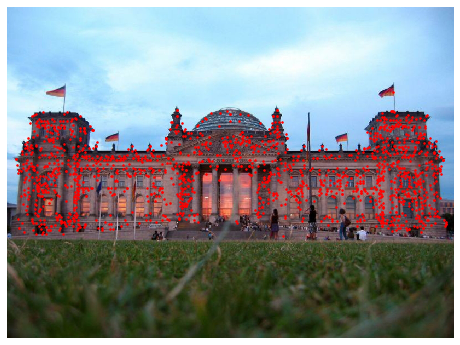

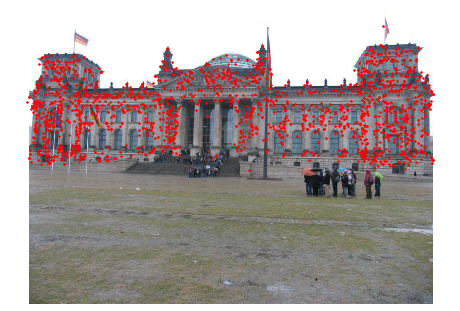

In [42]:
# Now let's reproject

# Get the points from one of the images
xy1s = data1['xys'][data1['valid'], :]
u_xy1s = xy1s.T

# Convert to homogeneous coordinates
u_xy1s = np.concatenate([u_xy1s, np.ones([1, u_xy1s.shape[1]])], axis=0)

# Get depth (on image 1) for each point
u_xy1s_int = u_xy1s.astype(np.int32)
z1 = data1['depth'][u_xy1s_int[1], u_xy1s_int[0]]

# Eliminate points on occluded areas
not_void = z1 > 0
print(f'Valid points: {sum(not_void)}/{len(not_void)}')
u_xy1s = u_xy1s[:, not_void]
z1 = z1[not_void]

# Move to world coordinates
n_xyz1s = np.dot(np.linalg.inv(K1), u_xy1s)
n_xyz1s = n_xyz1s * z1 / n_xyz1s[2, :]
xyz_w = np.dot(R1.T, n_xyz1s - T1[:,None])

# Reproject into image 2
n_xyz2s = np.dot(R2, xyz_w) + T2[:,None]
u_xy2s = np.dot(K2, n_xyz2s)
z2 = u_xy2s[2,:]
u_xy2s = u_xy2s / z2

fig1 = plt.figure(figsize=(8, 8))
f1 = plt.imshow(data1['image'])
plt.plot(u_xy1s[0,:], u_xy1s[1,:], 'r.', markersize=ms)
plt.axis('off')
plt.show()

fig2 = plt.figure(figsize=(8, 8))
f2 = plt.imshow(data2['image'])
plt.plot(u_xy2s[0,:], u_xy2s[1,:], 'r.', markersize=ms)
plt.axis('off')
plt.show()